### Experiment 1

This graph has only one NE.

In [1]:
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt

In [2]:
def softmax(x, axis=None):
    return np.exp(x - logsumexp(x, axis=axis, keepdims=True))
def logsumexp(a, axis=None, b=None, keepdims=False, return_sign=False):
    
    a = _asarray_validated(a, check_finite=False)
    if b is not None:
        a, b = np.broadcast_arrays(a, b)
        if np.any(b == 0):
            a = a + 0.  # promote to at least float
            a[b == 0] = -np.inf

    a_max = np.amax(a, axis=axis, keepdims=True)

    if a_max.ndim > 0:
        a_max[~np.isfinite(a_max)] = 0
    elif not np.isfinite(a_max):
        a_max = 0

    if b is not None:
        b = np.asarray(b)
        tmp = b * np.exp(a - a_max)
    else:
        tmp = np.exp(a - a_max)

    # suppress warnings about log of zero
    with np.errstate(divide='ignore'):
        s = np.sum(tmp, axis=axis, keepdims=keepdims)
        if return_sign:
            sgn = np.sign(s)
            s *= sgn  # /= makes more sense but we need zero -> zero
        out = np.log(s)

    if not keepdims:
        a_max = np.squeeze(a_max, axis=axis)
    out += a_max

    if return_sign:
        return out, sgn
    else:
        return out
def _asarray_validated(a, check_finite=True,
                       sparse_ok=False, objects_ok=False, mask_ok=False,
                       as_inexact=False):
    if not sparse_ok:
        import scipy.sparse
        if scipy.sparse.issparse(a):
            msg = ('Sparse matrices are not supported by this function. '
                   'Perhaps one of the scipy.sparse.linalg functions '
                   'would work instead.')
            raise ValueError(msg)
    if not mask_ok:
        if np.ma.isMaskedArray(a):
            raise ValueError('masked arrays are not supported')
    toarray = np.asarray_chkfinite if check_finite else np.asarray
    a = toarray(a)
    if not objects_ok:
        if a.dtype is np.dtype('O'):
            raise ValueError('object arrays are not supported')
    if as_inexact:
        if not np.issubdtype(a.dtype, np.inexact):
            a = toarray(a, dtype=np.float_)
    return a

In [3]:
# helper function

def VI_congestion(itera, theta=0.0001, discount_factor=1.0):
    policy_list = []
    policy_random = np.ones((nS,nA))
    policy_list.append(policy_random)
    
    def one_step_lookahead(state, V):
        A = np.zeros(nA)
        for a in range(nA):
            for prob, next_state, reward, done in P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A

    V = np.zeros(nS)
    iter = 0
    dl = []
    vl = []

    for _ in range(itera):
        iter += 1
        print(iter)
        # Stopping condition
        delta = 0
        # Update each state...
        policy_iter = np.zeros([nS, nA])
        for s in range(nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
            best_action_value = np.max(A)
            ########################### method 1 ################################
#             policy_iter[s, [i for i, val in enumerate(A) if (val == max(A))]] = 1.0
            best_action = np.argmax(A)
            policy_iter[s, best_action] = 1.0
            ########################### method 2 ################################
            '''
            policy_t = softmax(A)
            policy_iter[s, :] = policy_t
            '''
            ########################### ssssssss ################################
            
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10.
            V[s] = best_action_value

        vl.append(V.copy())
        dl.append(delta)
        policy_list.append(policy_iter)

        # Check if we can stop
        print("debug-> iter={}, delta={:.5f}, V={}".format(iter, delta, V))
#         if delta < theta:
#             break

        ####################################################################
        '''
        # Create a deterministic policy using the optimal value function
        policy_iter = np.zeros([nS, nA])
        for s in range(nS):
            # One step lookahead to find the best action for this state
            A = one_step_lookahead(s, V)
            print(A)
            # pdb.set_trace()
#             policy_t = softmax(A)
#             best_action = np.argmax(A)
            # Always take the best action
            policy_iter[s, [i for i, val in enumerate(A) if (val == max(A))]] = 1.0
            # soft policy
#             policy_iter[s, :] = policy_t # record action values
        policy_list.append(policy_iter)
        # print("policy", policy_iter)
        '''
        ######################################################################

    #########################s##############################
    # Create a deterministic policy using the optimal value function
    policy = np.zeros([nS, nA])
    for s in range(nS):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s, best_action] = 1.0
        
        '''
        policy[s, [i for i, val in enumerate(A) if (val == max(A))]] = 1.0
        '''
    ##########################e##############################

    return policy, V, dl, vl, policy_list, A

In [4]:
def policy_evl(R, policy, theta=0.0001, discount_factor=1.0):

    #########################################################################
    '''
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(nA)
        for a in range(nA):
            for prob, next_state, reward, done in P[state][a]:
                A[a] += prob * (discount_factor * R[s][a]) * policy[s][a]

        return A
    '''
    ##########################################################################
    
    def one_step_lookahead(state, V):
        A = np.zeros(nA)
        for a in range(nA):
            for prob, next_state, reward, done in P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    V = np.zeros(nS)
    iter = 0
    dl = []
    vl = []
    V_mean = np.zeros(nS)
    
    while True:
        iter += 1
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
            print(A)
#             print(A * np.array(policy[s,:]))
            '''
            V_mean[s] = np.sum(A * np.array(policy[s,:]).astype(np.int16))  / np.count_nonzero( np.array(policy[s,:]).astype(np.int16))
            '''
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(V_mean[s] - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10.
            V[s] = V_mean[s]
            
        vl.append(V.copy())
        dl.append(delta)
        # Check if we can stop
        if delta < theta:
            break
            
    V_k = V[0]
    
    return policy, V, dl, vl, V_k

In [21]:
def Bk(dl,vl):

    ## plot delta
    iter = len(dl)
    x = np.arange(1, iter+1)
    plt.plot(x, dl, linewidth=1.8)
    plt.scatter(x, dl, marker='o')
    plt.xlabel('#Iter')
    plt.ylabel('|$B_k-B_{k-1}$|')
    plt.title('Sanity check: Delta convergence')
    plt.savefig(r'\Users\Tongtong\Desktop\UCL CSML\毕业设计\sanity_Delta.jpg')
    plt.show()

    ## plot values
    y = np.array(vl).mean(-1)
    plt.plot(x.reshape(iter, 1), y, linewidth=1.8)
    plt.scatter(x, y)
    plt.xlabel('#Iter')
    plt.ylabel('$B_k$')
    plt.title("Sanity check: two agents")
    plt.savefig(r'\Users\Tongtong\Desktop\UCL CSML\毕业设计\sanity_Bk.jpg')
    plt.show()

In [11]:
def policy_evl(R, policy, theta=0.0001, discount_factor=1.0):

    #########################################################################
    '''
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(nA)
        for a in range(nA):
            for prob, next_state, reward, done in P[state][a]:
                A[a] += prob * (discount_factor * R[s][a]) * policy[s][a]

        return A
    '''
    ##########################################################################
    
    def one_step_lookahead(state, V):
        A = np.zeros(nA)
        for a in range(nA):
            for prob, next_state, reward, done in P[state][a]:
                A[a] += prob * (R[s][a] + discount_factor * V[next_state])
        return A
    
    
    V = np.zeros(nS)
    iter = 0
    dl = []
    vl = []
    V_mean = np.zeros(nS)
    
    while True:
        iter += 1
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
#             print(A)
#             print(A * np.array(policy[s,:]))
            
            V_mean[s] = np.sum(A * np.array(policy[s,:]).astype(np.int16))  / np.count_nonzero( np.array(policy[s,:]).astype(np.int16))
            
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(V_mean[s] - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10.
            V[s] = V_mean[s]
#         print(V)
            
        vl.append(V.copy())
        dl.append(delta)
        # Check if we can stop
        if delta < theta:
            break
            
    V_k = V[0]
    
    return policy, V, dl, vl, V_k

In [17]:
def total_return(policy_list):
    # total return for agent 1
    print("--> Start doing total return")
    v1 = []
    v2 = []
    vk1 = []
    vk2 = []
    iter = len(policy_list)

    for idx in range(iter):
        # print("debug-->", idx)
        policy = policy_list[idx]

        _, v, _, vl, v_k = policy_evl(R1,policy)
        v1.append(v.copy())
        vk1.append(v_k)
        
        _, v, _, vl, v_k = policy_evl(R2,policy)
        v2.append(v.copy())
        vk2.append(v_k)
        

#     v1 = np.array(v1)
#     v2 = np.array(v2)
#     x = np.arange(0, iter)
#     print(v1)
#     mean_v = v1.sum(-1)
#     print(mean_v)
#     plt.plot(x, mean_v, linewidth=1.8)
#     plt.scatter(x, mean_v)
#     plt.xlabel('#Iter')
#     plt.ylabel('$V_k$ for agent 1')
#     plt.show()

    x = np.arange(1, iter+1)
    print(vk1)
    plt.plot(x, vk1, linewidth=1.8, label='player1')
    plt.scatter(x, vk1)
    plt.xlabel('#Iter')
    plt.ylabel('$G_t$')
#     plt.show()
    
    x = np.arange(1, iter+1)
    print(vk2)
    plt.plot(x, vk2, linewidth=1.8, label='player2')
    plt.scatter(x, vk2)
    plt.xlabel('#Iter')
    plt.ylabel('$G_k$')
    plt.legend()
    plt.title('Sanity check: Total return')
    plt.savefig(r'\Users\Tongtong\Desktop\UCL CSML\毕业设计\sanity_Gt.jpg')
    plt.show()

Graph setting

In [6]:
# phi
# only one NE
nS = 8
nA = 4

# phi
payoff = [
    [-3, -3, -3, -6], # [s,s]
    [-99, -1, -1, -3], # [a,a]
    [-7, -2, -8, -3], # [a,b]
    [-16, -9, -9, -6], # [b,b]
    [-6, -10, -10, -10], # [c,c]
    [-10, -8, -8, -10], # [c,d]
    [-10, -10, -10, -10],  # [d,d]
    [0, 0, 0, 0]     # [T,T]
]

transition =[
    [1, 2, 2, 3],
    [4, 5, 5, 6],
    [4, 5, 5, 6],
    [4, 5, 5, 6],
    [7, 7, 7, 7],
    [7, 7, 7, 7],
    [7, 7, 7, 7],
    [7, 7, 7, 7]
]

# cost
R1 = [
    [-2, -1, -2, -4], # [s,s]
    [-99, 0, -1, -2], # [a,a]
    [0, 0, -1, -1], # [a,b]
    [-9, -7, -2, -4], # [b,b]
    [-3, -10, -10, -10], # [c,c]
    [-10, -3, -5, -10], # [c,d]
    [-10, -10, -10, -5],  # [d,d]
    [0, 0, 0, 0]     # [T,T]
]

# R1 = R2
R2 = [
    [-2, -2, -1, -4], # [s,s]
    [-99, -1, 0, -2], # [a,a]
    [-7, -2, -7, -2], # [a,b]
    [-9, -2, -7, -4], # [b,b]
    [-3, -10, -10, -10], # [c,c]
    [-10, -5, -3, -10], # [c,d]
    [-10, -10, -10, -5],  # [d,d]
    [0, 0, 0, 0]     # [T,T]
]

In [7]:
P = dict()
for s in range(nS):
    P[s] = {a : [] for a in range(nA)}
    
for state in range(nS):
    for a in range(nA):
        tmp = []
        prob = 1
        snext = transition[state][a]
        reward = payoff[state][a]
        done = False
        if snext == 7:
            done = True
        # prob, next_state, reward, done
        tmp.extend([(prob, snext, reward, done)])
        P[state][a] = tmp


In [9]:
policy, V, dl, vl, policy_list, A = VI_congestion(10)

1
debug-> iter=1, delta=10.00000, V=[ -3.  -1.  -2.  -6.  -6.  -8. -10.   0.]
2
debug-> iter=2, delta=10.00000, V=[ -4.  -9. -10. -16.  -6.  -8. -10.   0.]
3
debug-> iter=3, delta=8.00000, V=[-12.  -9. -10. -16.  -6.  -8. -10.   0.]
4
debug-> iter=4, delta=0.00000, V=[-12.  -9. -10. -16.  -6.  -8. -10.   0.]
5
debug-> iter=5, delta=0.00000, V=[-12.  -9. -10. -16.  -6.  -8. -10.   0.]
6
debug-> iter=6, delta=0.00000, V=[-12.  -9. -10. -16.  -6.  -8. -10.   0.]
7
debug-> iter=7, delta=0.00000, V=[-12.  -9. -10. -16.  -6.  -8. -10.   0.]
8
debug-> iter=8, delta=0.00000, V=[-12.  -9. -10. -16.  -6.  -8. -10.   0.]
9
debug-> iter=9, delta=0.00000, V=[-12.  -9. -10. -16.  -6.  -8. -10.   0.]
10
debug-> iter=10, delta=0.00000, V=[-12.  -9. -10. -16.  -6.  -8. -10.   0.]


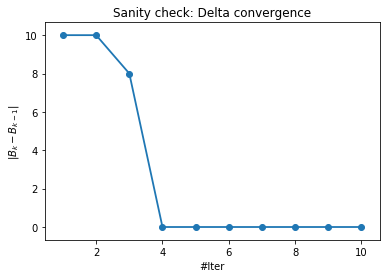

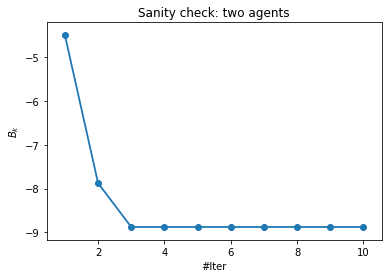

In [22]:
Bk(dl,vl)

--> Start doing total return
[-18.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0]
[-20.0, -8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -8.0, -8.0]


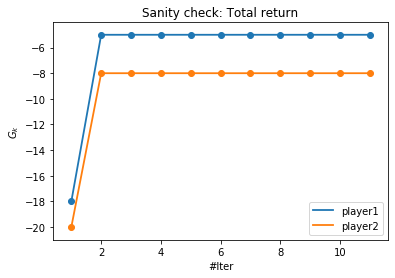

In [18]:
total_return(policy_list)

plot

In [227]:
import networkx as nx

TypeError: 'NoneType' object is not subscriptable

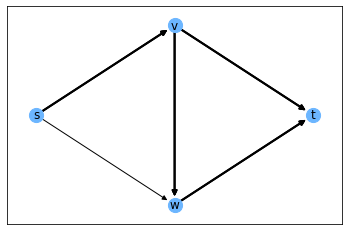

In [232]:
G = nx.DiGraph()  # 创建一个空的有向图

# 节点的个数
# num = 4
# nodes = list(range(num))  # [0,1,2,3,4,5]
# 将节点添加到网络中
# G.add_nodes_from(nodes)  # 从列表中加点
road_nodes = {'s': {1: 1}, 'v': {2: 2}, 'w': {3: 3}, 't': {4: 4}}
road_edges = [('s', 'v'), ('s', 'w'), ('v', 'w'), ('v', 't'), ('w', 't')]
G.add_nodes_from(road_nodes)
G.add_edges_from(road_edges)
# edges = []  # 存放所有的边，构成无向图（去掉最后一个结点，构成一个环）
# for idx in range(num - 1):
#     edges.append((idx, idx + 1))
# edges.append((num - 1, 0))
#  将所有边加入网络
# G.add_edges_from(edges)

e1 = ('s', 'v')
e2 = ('s', 'w')
e3 = ('v', 'w')
e4 = ('v', 't')
e5 = ('w', 't')
path_list = [
    [[e1, e1], [e1, e2], [e2, e1], [e2, e2]],
    [[e4, e4], [e4, e3], [e3, e4], [e3, e3]],
    [[e3, e5], [e3], [e4, e5], [e4]],
    [[e5, e3], [e5, e4], [e3], [e4]],
    [[e5, e5], [e5], [e5], [None]],
    [[e5], [None], [e5], [None]],
    [[e5], [e5], [None], [None]],
    [[None], [None], [None], [None]]
]
edge = []
for i in range(6):
    for j in range(4):
        if policy[i][j] == 1:
            # if path_list[i][j][0] is not None:
                edge.append(path_list[i][j])

# G.add_edges_from(edge)
# nx.draw_networkx(G)

# 每个节点对应坐标坐标
coordinates = [[0, 2.5], [5, 5], [5, 0], [10, 2.5]]
# 可导入自己所需的数据
# np.loadtxt()

vnode = np.array(coordinates)
npos = dict(zip(road_nodes, vnode))  # 获取节点与坐标之间的映射关系，用字典表示
# 若显示多个图，可将所有节点放入该列表中
# pos = {}
# pos.update(npos)
nlabels = dict(zip(road_nodes, road_nodes))  # 标志字典，构建节点与标识点之间的关系

# draw_networkx_nodes(G, pos, nodelist=None,node_size=300,node_color='r',node_shape='o',alpha=1.0,cmap=None,vmin=None,vmax=None,ax=None,linewidths=None,label=None,**kwds)

# draw_networkx_edges(G, pos, edgelist=None, width=1.0, edge_color='k', style='solid', alpha=1.0, edge_cmap=None, edge_vmin=None, edge_vmax=None, ax=None, arrows=True, label=None, **kwds)

# draw_networkx_labels(G, pos, labels=None, font_size=12, font_color='k', font_family='sans-serif', font_weight='normal', alpha=1.0, bbox=None, ax=None, **kwds)

nx.draw_networkx_nodes(G, npos, node_size=200, node_color="#6CB6FF")  # 绘制节点
nx.draw_networkx_edges(G, npos, road_edges, width=1)  # 绘制边
nx.draw_networkx_labels(G, npos, nlabels)  # 标签

for j in range(len(edge)):
    nx.draw_networkx_edges(G, npos, edge[j], width=2)  # 绘制optimal path
    # pdb.set_trace()

x_max, y_max = vnode.max(axis=0)  # 获取每一列最大值
x_min, y_min = vnode.min(axis=0)  # 获取每一列最小值
x_num = (x_max - x_min) / 10
y_num = (y_max - y_min) / 10
# print(x_max, y_max, x_min, y_min)
plt.xlim(x_min - x_num, x_max + x_num)
plt.ylim(y_min - y_num, y_max + y_num)
plt.title('Policy')
# plt.show()
# plt.savefig(f'./network-fig_{game_name}_Bk.pdf')


In [ ]:
G = nx.DiGraph()  # 创建一个空的有向图

# 节点的个数
# num = 4
# nodes = list(range(num))  # [0,1,2,3,4,5]
# 将节点添加到网络中
# G.add_nodes_from(nodes)  # 从列表中加点
road_nodes = {'A': {1: 1}, 'B': {2: 2}, 'C': {3: 3}, 'D': {4: 4}, 'E':{5: 5}, 'F':{6:6}}
road_edges = [('A', 'B'), ('A', 'C'), ('B', 'D'), ('C', 'F'), ('D', 'F')]
G.add_nodes_from(road_nodes)
G.add_edges_from(road_edges)
# edges = []  # 存放所有的边，构成无向图（去掉最后一个结点，构成一个环）
# for idx in range(num - 1):
#     edges.append((idx, idx + 1))
# edges.append((num - 1, 0))
#  将所有边加入网络
# G.add_edges_from(edges)

e1 = ('A', 'B')
e2 = ('A', 'C')
e3 = ('B', 'D')
e4 = ('C', 'F')
e5 = ('D', 'F')
path_list = [
    [[e1, e1], [e1, e2], [e2, e1], [e2, e2]],
    [[e4, e4], [e4, e3], [e3, e4], [e3, e3]],
    [[e3, e5], [e3], [e4, e5], [e4]],
    [[e5, e3], [e5, e4], [e3], [e4]],
    [[e5, e5], [e5], [e5], [None]],
    [[e5], [None], [e5], [None]],
    [[e5], [e5], [None], [None]],
    [[None], [None], [None], [None]]
]
edge = []
for i in range(6):
    for j in range(4):
        if policy[i][j] == 1:
            # if path_list[i][j][0] is not None:
                edge.append(path_list[i][j])